In [59]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, LSHForest
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.feature_extraction import DictVectorizer

In [2]:
def load_data():
    train = pd.read_csv('data/evo_train.csv.gz', compression='gzip', index_col='id')
    categories = pd.read_csv('data/categories_parsed.csv.gz', compression='gzip', index_col='GROUP_ID')
    data = train.join(categories, on='GROUP_ID')
    return data

In [3]:
data = load_data()
data.head()

,NAME,GROUP_ID,category,sub_category
id,,,,
0,"Пиво ""Жигулевское"" 0,5 л. св.",35,Алкоголь,"Пиво, слабоалкогольные напитки"
1,СОУС ТОМАТНЫЙ БУЗДЯК 670Г ТАТАРСКИЙ /8,6,Прод,Продукты питания
2,Сигареты Esse SS Exchange,7,Непрод,Табачные изделия
3,Петрушка,6,Прод,Продукты питания
4,пиво ягерь,35,Алкоголь,"Пиво, слабоалкогольные напитки"


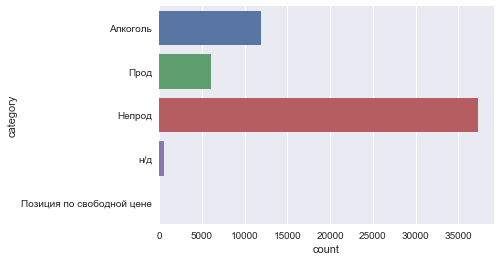

In [36]:
sns.countplot(y='category', data=data)

In [4]:
def prepare_data_baseline(data):
    X = data['NAME']
    y = data['category']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    test = pd.DataFrame(index=y_test.index)
    test['NAME'] = X_test
    test['category'] = y_test
    
    return X_train, X_test, y_train, y_test

In [5]:
from sklearn.metrics import accuracy_score, log_loss, classification_report

def show_metrics(y_true, y_pred, y_pred_proba):
    print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
    print("LogLoss: {}".format(log_loss(y_true, y_pred_proba)))
    print(classification_report(y_true, y_pred))

In [120]:
def baseline(data, prepare_data):
    X_train, X_test, y_train, y_test = prepare_data(data)
    vectorizer = CountVectorizer(binary=True)
    
    pipeline = Pipeline([
            ('count_vectorizer', vectorizer),
#             ('best', TruncatedSVD(n_components=100)),
#            ('clf', KNeighborsClassifier(n_neighbors=4))
            ('clf_category', MultinomialNB())
#             ('clf', SGDClassifier(loss='log'))
        ])

    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    pred_proba = pipeline.predict_proba(X_test)
    print("Vocabulary length: {}".format(len(vectorizer.vocabulary_)))
    show_metrics(y_test, pred, pred_proba)
    
    pred_df = pd.DataFrame(pred, index=X_test.index,columns=['predicted'])
    pred_df['real'] = y_test
    pred_df['NAME'] = X_test
    errors = pred_df[pred_df['real'] != pred_df['predicted']]
    
    return errors, vectorizer

In [119]:
errors_baseline, vectorizer = baseline(data, prepare_data_baseline)
print("Errors count: {}".format(errors_baseline.shape[0]))
errors_baseline.head()

Vocabulary length: 38416
Accuracy: 0.9214106695309703
LogLoss: 0.8630081025265496
                           precision    recall  f1-score   support

                 Алкоголь       0.92      0.94      0.93      3583
                   Непрод       0.92      0.97      0.95     11214
Позиция по свободной цене       1.00      0.50      0.67         4
                     Прод       0.93      0.56      0.70      1774
                      н/д       0.71      0.87      0.78       183

              avg / total       0.92      0.92      0.92     16758

Errors count: 1317


,predicted,real,NAME
id,,,
6561,Непрод,Алкоголь,"БИТОКСИБАЦИЛЛИН, П/Август/20гр"
23469,Непрод,Прод,Смоква яблочная 30 гр.
47200,Непрод,Прод,"ТВОРОГ ПЕРШИНСКОЕ 1,8% П/ПАКЕТ 450ГР."
48333,Непрод,Алкоголь,набор подарочный для вина
15024,Непрод,Прод,Зефир Воздушный поцелуй клубничный


In [81]:
#import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

def boosting(data, prepare_data):
    X_train, X_test, y_train, y_test = prepare_data(data)
    vectorizer = CountVectorizer()
    pipeline = Pipeline([
            ('count_vectorizer', vectorizer),
            #('clf_category', xgb.XGBClassifier(max_depth=15, seed=42, n_estimators=200))
            ('clf', RandomForestClassifier(random_state=42, n_estimators=50))
        ])

    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    pred_proba = pipeline.predict_proba(X_test)
    print("Vocabulary length: {}".format(len(vectorizer.vocabulary_)))
    show_metrics(y_test, pred, pred_proba)
    
    pred_df = pd.DataFrame(pred, index=X_test.index,columns=['predicted'])
    pred_df['real'] = y_test
    pred_df['NAME'] = X_test
    errors = pred_df[pred_df['real'] != pred_df['predicted']]
    
    return errors, vectorizer

In [82]:
errors, vectorizer = boosting(data, prepare_data_baseline)
print("Errors count: {}".format(errors.shape[0]))
errors.head()

Vocabulary length: 38416
Accuracy: 0.9553646019811434
LogLoss: 0.45778997019437323
                           precision    recall  f1-score   support

                 Алкоголь       0.98      0.94      0.96      3583
                   Непрод       0.95      0.99      0.97     11214
Позиция по свободной цене       1.00      0.50      0.67         4
                     Прод       0.92      0.79      0.85      1774
                      н/д       0.94      0.87      0.90       183

              avg / total       0.96      0.96      0.95     16758

Errors count: 748


,predicted,real,NAME
id,,,
33515,Непрод,Алкоголь,литовское 1 л+бутылка
6561,Непрод,Алкоголь,"БИТОКСИБАЦИЛЛИН, П/Август/20гр"
48333,Непрод,Алкоголь,набор подарочный для вина
1182,Непрод,Прод,ХЛЕБЦЫ С ГРЕЧИХОЙ ЯНТАРЬ 185Г
43089,Непрод,Прод,Малена / Акконд


In [110]:
def ensemble(vectorizer, data, prepare_data):
    X_train, X_test, y_train, y_test = prepare_data(data)
    
    pipeline = Pipeline([
            ('count_vectorizer', vectorizer),
            ('clf', VotingClassifier(
                [
                    ('knn', KNeighborsClassifier(n_neighbors=4)),
                    ('nb', MultinomialNB()), 
                    ('rf',RandomForestClassifier(random_state=42, n_estimators=50))], 
                voting='soft', weights=[0.2 ,0.85, 0.65]
            ))
        ])

    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    pred_proba = pipeline.predict_proba(X_test)
    print("Vocabulary length: {}".format(len(vectorizer.vocabulary_)))
    show_metrics(y_test, pred, pred_proba)
    
    pred_df = pd.DataFrame(pred, index=X_test.index,columns=['predicted'])
    pred_df['real'] = y_test
    pred_df['NAME'] = X_test
    errors = pred_df[pred_df['real'] != pred_df['predicted']]
    
    return errors, vectorizer

In [122]:
errors, vectorizer = ensemble(CountVectorizer(max_features=21000),data, prepare_data_baseline)
print("Errors count: {}".format(errors.shape[0]))
errors.head()

Vocabulary length: 21000
Accuracy: 0.9678959303019453
LogLoss: 0.12667486844203257
                           precision    recall  f1-score   support

                 Алкоголь       0.98      0.96      0.97      3583
                   Непрод       0.97      0.99      0.98     11214
Позиция по свободной цене       1.00      0.50      0.67         4
                     Прод       0.95      0.85      0.90      1774
                      н/д       0.99      0.86      0.92       183

              avg / total       0.97      0.97      0.97     16758

Errors count: 538


,predicted,real,NAME
id,,,
6561,Непрод,Алкоголь,"БИТОКСИБАЦИЛЛИН, П/Август/20гр"
48333,Непрод,Алкоголь,набор подарочный для вина
43089,Непрод,Прод,Малена / Акконд
21696,Непрод,Алкоголь,Лавила Нанни сух.150
49520,Прод,Непрод,Кофе Hausbrandt Nero Espresso


In [114]:
from nltk.stem.snowball import RussianStemmer

def stemmer_vectorizer():
    stemmer = RussianStemmer()
    analyzer = CountVectorizer().build_analyzer()
    
    def stemmed_words(doc):
        return (stemmer.stem(w) for w in analyzer(doc))

    vectorizer = CountVectorizer(analyzer=stemmed_words, max_features=30000)
    return vectorizer

In [115]:
errors_stemmer, vectorizer = ensemble(stemmer_vectorizer(), data, prepare_data_baseline)
print("Errors count: {}".format(errors_stemmer.shape[0]))
errors_stemmer.head()

Vocabulary length: 30000
Accuracy: 0.9664637784938537
LogLoss: 0.12899636437403525
                           precision    recall  f1-score   support

                 Алкоголь       0.98      0.96      0.97      3583
                   Непрод       0.96      0.99      0.98     11214
Позиция по свободной цене       1.00      0.50      0.67         4
                     Прод       0.95      0.85      0.90      1774
                      н/д       0.99      0.85      0.91       183

              avg / total       0.97      0.97      0.97     16758

Errors count: 562


,predicted,real,NAME
id,,,
6561,Непрод,Алкоголь,"БИТОКСИБАЦИЛЛИН, П/Август/20гр"
48333,Непрод,Алкоголь,набор подарочный для вина
50666,Непрод,Прод,Бутерброд №44
43089,Непрод,Прод,Малена / Акконд
21696,Непрод,Алкоголь,Лавила Нанни сух.150


In [116]:
import string
import re

def prepare_data_numbers_fix(data):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    X = (data['NAME'] + '.') \
        .str.lower() \
        .replace(regex," ").str \
        .replace('\d+', '') \
        .str.replace(" л ", " литр ") \
        .str.replace(" г ", ' грамм ') \
        .str.replace(" кг ", ' килограмм ') \
        .str.replace(" мг ", ' миллиграмм ') \
        .str.replace(" мл ", ' миллилитр ') \
        .str.replace(" шт ", " штук ") \
        .str.replace(" см ", " сантиметр ") \
        .str.replace(" м ", " метр ") \
        .str.replace(' д ', ' для ')
    
    y = data['category']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    test = pd.DataFrame(index=y_test.index)
    test['NAME'] = X_test
    test['category'] = y_test
    
    return X_train, X_test, y_train, y_test

In [117]:
errors_baseline_fixed, vectorizer = baseline(data, prepare_data_numbers_fix)
print("Errors count: {}".format(errors_baseline_fixed.shape[0]))
errors_baseline_fixed.head()

Vocabulary length: 30947
Accuracy: 0.8407327843418069
LogLoss: 2.8906944946783057
                           precision    recall  f1-score   support

                 Алкоголь       0.98      0.91      0.94      3583
                   Непрод       0.97      0.86      0.91     11214
Позиция по свободной цене       1.00      0.50      0.67         4
                     Прод       0.93      0.54      0.68      1774
                      н/д       0.08      1.00      0.14       183

              avg / total       0.96      0.84      0.89     16758

Errors count: 2669


,predicted,real,NAME
id,,,
30006,н/д,Непрод,sobraniegolds
31853,н/д,Непрод,фиксация коронки изготовленной в другом учрежд...
21126,н/д,Непрод,termal радиатор кондиционера hyndai
6561,Прод,Алкоголь,битоксибациллин п август гр
23469,н/д,Прод,смоква яблочная гр


In [200]:
errors, vectorizer = boosting(data, prepare_data_numbers_fix)
print("Errors count: {}".format(errors.shape[0]))
errors.head()

Vocabulary length: 30945
Accuracy: 0.9328678839957035
LogLoss: 0.20956943042317075
                           precision    recall  f1-score   support

                 Алкоголь       0.99      0.90      0.95      3583
                   Непрод       0.93      0.98      0.95     11214
Позиция по свободной цене       1.00      0.75      0.86         4
                     Прод       0.84      0.70      0.76      1774
                      н/д       0.98      0.87      0.92       183

              avg / total       0.93      0.93      0.93     16758

Errors count: 1125


,predicted,real,NAME
id,,,
6561,Прод,Алкоголь,битоксибациллин п август гр
48333,Непрод,Алкоголь,набор подарочный для вина
15024,Непрод,Прод,зефир воздушный поцелуй клубничный
50666,Непрод,Прод,бутерброд №
38717,Прод,Непрод,ушастый нянь weight


In [178]:
errors, vectorizer = predict_with_stemmer(data, prepare_data_numbers_fix)
print("Errors count: {}".format(errors.shape[0]))
errors.head()

Vocabulary length: 23457
Accuracy: 0.9634204559016589
LogLoss: 0.12338980122092645
                           precision    recall  f1-score   support

                 Алкоголь       0.97      0.96      0.96      3583
                   Непрод       0.97      0.99      0.98     11214
Позиция по свободной цене       0.00      0.00      0.00         4
                     Прод       0.93      0.84      0.89      1774
                      н/д       0.99      0.84      0.91       183

              avg / total       0.96      0.96      0.96     16758

Errors count: 613


/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,predicted,real,NAME
id,,,
6561,Непрод,Алкоголь,битоксибациллин п август гр
49297,Алкоголь,Непрод,ценникодержатель полочный самоклеющийся dbr ...
48333,Непрод,Алкоголь,набор подарочный для вина
43089,Непрод,Прод,малена акконд
49520,Прод,Непрод,кофе hausbrandt nero espresso
